In [ ]:
import os
import re
import pandas as pd
import numpy as np

def process_trial_data(file_path):
    """
    Processes a CSV file containing multiple trials of the same gesture.
    Each file represents a different gesture, and within the file, each segment represents a trial.
    """
    df = pd.read_csv(file_path, header=None)
    df = df.iloc[:, 1:].reset_index(drop=True)  # Remove the timestamp column
    
    # Identify empty rows indicating trial separation
    empty_rows = df[(df == 0).all(axis=1)].index.tolist()
    print(f"Detected empty rows (trial separators) at indices: {empty_rows}")
    
    trials = []
    start_idx = 0
    for idx in empty_rows + [len(df)]:
        if start_idx < idx:
            trials.append(df.iloc[start_idx:idx].reset_index(drop=True))
        start_idx = idx + 1
    
    processed_trials = []
    for i, trial in enumerate(trials):
        data = trial.to_numpy()
        print(f"Processing Trial {i+1} of Gesture with {data.shape[0]} samples")
        
        # Standardizing trial length to 1000 samples via interpolation if needed
        if data.shape[0] > 1000:
            data = data[:1000]
        if data.shape[0] < 1000:
            x_old = np.linspace(0, 1, data.shape[0])
            x_new = np.linspace(0, 1, 1000)
            data = np.array([np.interp(x_new, x_old, data[:, j]) for j in range(data.shape[1])]).T
        
        # Creating overlapping windows of size 100 with a stride of 50
        windows = []
        for start in range(0, 1000 - 100 + 1, 50):
            windows.append(data[start:start + 100])
        
        windows = np.array(windows)
        windows = np.expand_dims(windows, axis=0)  # Expand dimensions for batch processing
        trial_id = np.full((1, windows.shape[1], 100, 1), i + 1)  # Assign trial ID
        windows = np.concatenate((trial_id, windows), axis=-1)  # Append trial ID to data
        processed_trials.append(windows)
    
    final_data = np.concatenate(processed_trials, axis=0)
    print(f"Processed {len(processed_trials)} trials with shape: {final_data.shape}")
    return final_data

def process_all_gesture_files(folder_path):
    """
    Processes all CSV files in a folder, each representing a different gesture.
    Saves the processed data and labels.
    """
    all_files = [f for f in os.listdir(folder_path) if f.endswith(".csv")]
    all_files = sorted(all_files, key=lambda x: int(re.search(r"sensor_data(\d+).csv", x).group(1)))
    all_files = [os.path.join(folder_path, f) for f in all_files]
    
    all_data = []
    all_labels = []
    
    for label, file_path in enumerate(all_files, start=1):
        print(f"Processing Gesture File: {file_path} (Gesture ID: {label})")
        data = process_trial_data(file_path)
        data[:, :, :, 0] = label  # Assign gesture ID to the first channel
        all_data.append(data)
        all_labels.append(np.full((data.shape[0],), label))
    
    final_dataset = np.concatenate(all_data, axis=0)
    final_labels = np.concatenate(all_labels, axis=0)
    data_path = os.path.join(folder_path, "processed_gesture_data.npy")
    label_path = os.path.join(folder_path, "gesture_labels.npy")
    np.save(data_path, final_dataset)
    np.save(label_path, final_labels)
    print("Processed trial data and labels saved.")
    
    return final_dataset, final_labels

In [10]:
folder_path = r"new_collect\fzh"  # 修改为你的CSV文件夹路径
final_data, final_labels = process_all_gesture_files(folder_path)
print("Final data shape:", final_data.shape)
print("Final labels shape:", final_labels.shape)

Processing Gesture File: new_collect\fzh\sensor_data1.csv (Gesture ID: 1)
Detected empty rows (trial separators) at indices: [997, 2004, 3011, 4021, 5027, 6035, 7047, 8060, 9071, 10081, 11091, 12099, 13106, 14109, 15119, 16125, 17137, 18144, 19154, 20164, 21172, 22183, 23193, 24204, 25210]
Processing Trial 1 of Gesture with 997 samples
Processing Trial 2 of Gesture with 1006 samples
Processing Trial 3 of Gesture with 1006 samples
Processing Trial 4 of Gesture with 1009 samples
Processing Trial 5 of Gesture with 1005 samples
Processing Trial 6 of Gesture with 1007 samples
Processing Trial 7 of Gesture with 1011 samples
Processing Trial 8 of Gesture with 1012 samples
Processing Trial 9 of Gesture with 1010 samples
Processing Trial 10 of Gesture with 1009 samples
Processing Trial 11 of Gesture with 1009 samples
Processing Trial 12 of Gesture with 1007 samples
Processing Trial 13 of Gesture with 1006 samples
Processing Trial 14 of Gesture with 1002 samples
Processing Trial 15 of Gesture wi

# visualization

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def visualize_gesture_data(file_path):
    """
    Reads and visualizes gesture data from a CSV file.
    
    Parameters:
    file_path (str): Path to the CSV file.
    
    Outputs:
    - A series of subplots showing gesture signals across different channels.
    """
    # Load CSV file
    df = pd.read_csv(file_path, header=None)
    
    # Ensure the file is not empty
    if df.empty:
        print("Error: The CSV file is empty.")
        return

    # Remove first column (assumed to be timestamps or unused)
    df = df.iloc[:, 1:].reset_index(drop=True)
    
    # Identify empty rows that indicate gesture separation
    empty_rows = df[(df == 0).all(axis=1)].index.tolist()
    print(f"Detected empty rows at indices: {empty_rows}")
    
    # Split the data into individual gestures
    gestures = []
    start_idx = 0
    for idx in empty_rows + [len(df)]:  # Ensure the last gesture is included
        if start_idx < idx:  # Avoid empty segments
            gestures.append(df.iloc[start_idx:idx].reset_index(drop=True))
        start_idx = idx + 1
    
    # Handle the case where no gestures are found
    if not gestures:
        print("Error: No gestures detected in the data.")
        return
    
    # Compute the number of rows and columns for subplots
    num_gestures = len(gestures)
    cols = 2  # Number of plots per row
    rows = (num_gestures + cols - 1) // cols  # Compute required rows
    
    # Create figure with subplots
    fig, axes = plt.subplots(rows, cols, figsize=(12, 5 * rows))
    axes = axes.flatten()
    
    # Define a set of distinct colors for each channel
    num_channels = gestures[0].shape[1]
    colors = plt.cm.viridis(np.linspace(0, 1, num_channels))

    # Process and plot each gesture
    for i, gesture in enumerate(gestures):
        data = gesture.to_numpy()
        print(f"Processing Gesture {i+1} with {data.shape[0]} samples")
        
        for j in range(data.shape[1]):  # Iterate over sensor channels
            axes[i].plot(data[:, j], label=f'Channel {j+1}', color=colors[j])
        
        axes[i].set_title(f'Gesture {i+1}')
        axes[i].set_xlabel('Samples')
        axes[i].set_ylabel('Sensor Values')
        axes[i].grid(True)  # Add grid for better readability

    # Add a legend only to one subplot (avoiding repetition)
    axes[0].legend(loc='upper right', fontsize='small')
    
    # Remove unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


Detected empty rows at indices: [997, 2004, 3011, 4021, 5027, 6035, 7047, 8060, 9071, 10081, 11091, 12099, 13106, 14109, 15119, 16125, 17137, 18144, 19154, 20164, 21172, 22183, 23193, 24204, 25210]
Processing Gesture 1 with 997 samples
Processing Gesture 2 with 1006 samples
Processing Gesture 3 with 1006 samples
Processing Gesture 4 with 1009 samples
Processing Gesture 5 with 1005 samples
Processing Gesture 6 with 1007 samples
Processing Gesture 7 with 1011 samples
Processing Gesture 8 with 1012 samples
Processing Gesture 9 with 1010 samples
Processing Gesture 10 with 1009 samples
Processing Gesture 11 with 1009 samples
Processing Gesture 12 with 1007 samples
Processing Gesture 13 with 1006 samples
Processing Gesture 14 with 1002 samples
Processing Gesture 15 with 1009 samples
Processing Gesture 16 with 1005 samples
Processing Gesture 17 with 1011 samples
Processing Gesture 18 with 1006 samples
Processing Gesture 19 with 1009 samples
Processing Gesture 20 with 1009 samples
Processing G

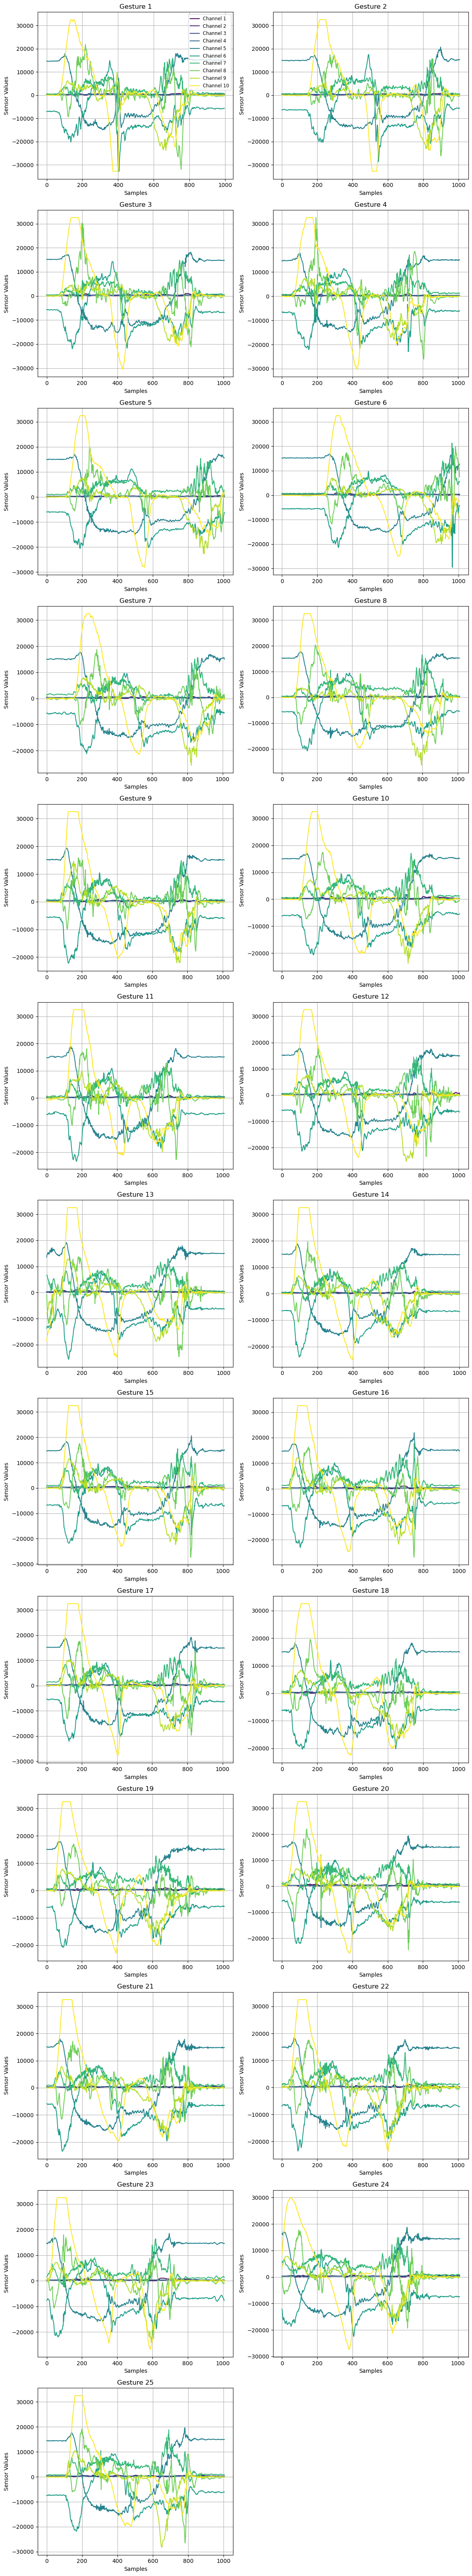

In [9]:
# 示例调用
file_path = r"new_collect\fzh\sensor_data1.csv"
visualize_gesture_data(file_path)

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def load_and_process_gestures(file_path):
    """
    Loads and processes gesture data from a CSV file, segments gestures based on zero rows,
    and verifies the shape before attempting to reshape.

    Parameters:
    - file_path (str): Path to the CSV file.

    Returns:
    - np.ndarray: Processed gesture data with shape (23, 25, 19, 100, 11).
    """
    # Load CSV file
    df = pd.read_csv(file_path, header=None)
    
    # Ensure the file is not empty
    if df.empty:
        print("Error: The CSV file is empty.")
        return None

    # Remove first column (assumed to be timestamps or unused)
    df = df.iloc[:, 1:].reset_index(drop=True)
    
    # Identify empty rows that indicate gesture separation
    empty_rows = df[(df == 0).all(axis=1)].index.tolist()
    print(f"Detected empty rows at indices: {empty_rows}")
    
    # Split the data into individual gestures
    gestures = []
    start_idx = 0
    for idx in empty_rows + [len(df)]:  # Ensure the last gesture is included
        if start_idx < idx:  # Avoid empty segments
            gestures.append(df.iloc[start_idx:idx].reset_index(drop=True))
        start_idx = idx + 1
    
    # Handle the case where no gestures are found
    if not gestures:
        print("Error: No gestures detected in the data.")
        return None
    
    # Print shape details for debugging
    print("\nGesture Shapes BEFORE reshaping:")
    for i, g in enumerate(gestures):
        print(f"Gesture {i+1}: {g.shape}")  # Print shape before reshaping

    # Expected total size per gesture
    expected_size = 25 * 19 * 100 * 11

    processed_gestures = []
    for g in gestures:
        g_array = g.to_numpy()

        if g_array.size != expected_size:
            print(f"⚠️ Warning: Gesture has {g_array.size} elements instead of {expected_size}!")
            return None  # Exit early if sizes don't match

        # Reshape only if the size matches
        g_array = g_array.reshape(25, 19, 100, 11)
        processed_gestures.append(g_array)

    return np.array(processed_gestures, dtype=np.float32)  # Shape: (23, 25, 19, 100, 11)

# Example Usage
file_path = r"C:\Users\theof\OneDrive - Imperial College London\Imperial MSc\AML Project\AML-Project\new_collect\fzh\sensor_data1.csv"
gesture_data = load_and_process_gestures(file_path)


Detected empty rows at indices: [997, 2004, 3011, 4021, 5027, 6035, 7047, 8060, 9071, 10081, 11091, 12099, 13106, 14109, 15119, 16125, 17137, 18144, 19154, 20164, 21172, 22183, 23193, 24204, 25210]

Gesture Shapes BEFORE reshaping:
Gesture 1: (997, 10)
Gesture 2: (1006, 10)
Gesture 3: (1006, 10)
Gesture 4: (1009, 10)
Gesture 5: (1005, 10)
Gesture 6: (1007, 10)
Gesture 7: (1011, 10)
Gesture 8: (1012, 10)
Gesture 9: (1010, 10)
Gesture 10: (1009, 10)
Gesture 11: (1009, 10)
Gesture 12: (1007, 10)
Gesture 13: (1006, 10)
Gesture 14: (1002, 10)
Gesture 15: (1009, 10)
Gesture 16: (1005, 10)
Gesture 17: (1011, 10)
Gesture 18: (1006, 10)
Gesture 19: (1009, 10)
Gesture 20: (1009, 10)
Gesture 21: (1007, 10)
Gesture 22: (1010, 10)
Gesture 23: (1009, 10)
Gesture 24: (1010, 10)
Gesture 25: (1005, 10)
⚠️ Warning: Gesture has 9970 elements instead of 522500!


In [26]:
import os
import re
import pandas as pd
import numpy as np

def process_gesture_data(file_path):
    df = pd.read_csv(file_path, header=None)
    df = df.iloc[:, 1:].reset_index(drop=True)  # 移除时间列
    
    empty_rows = df[(df == 0).all(axis=1)].index.tolist()
    print(f"Detected empty rows at indices: {empty_rows}")
    
    gestures = []
    start_idx = 0
    for idx in empty_rows + [len(df)]:
        if start_idx < idx:
            gestures.append(df.iloc[start_idx:idx].reset_index(drop=True))
        start_idx = idx + 1
    
    processed_gestures = []
    for i, gesture in enumerate(gestures):
        data = gesture.to_numpy()
        print(f"Processing Gesture {i+1} with {data.shape[0]} samples")
        
        if data.shape[0] > 1000:
            data = data[:1000]
        if data.shape[0] < 1000:
            x_old = np.linspace(0, 1, data.shape[0])
            x_new = np.linspace(0, 1, 1000)
            data = np.array([np.interp(x_new, x_old, data[:, j]) for j in range(data.shape[1])]).T
        
        windows = []
        for start in range(0, 1000 - 100 + 1, 50):
            windows.append(data[start:start + 100])
        
        windows = np.array(windows)
        windows = np.expand_dims(windows, axis=0)
        gesture_id = np.full((1, windows.shape[1], 100, 1), i + 1)
        windows = np.concatenate((gesture_id, windows), axis=-1)
        processed_gestures.append(windows)
    
    final_data = np.concatenate(processed_gestures, axis=0)
    return final_data

def process_all_gesture_files(folder_path):
    all_files = [f for f in os.listdir(folder_path) if f.endswith(".csv")]
    all_files = sorted(all_files, key=lambda x: int(re.search(r"sensor_data(\d+).csv", x).group(1)))
    all_files = [os.path.join(folder_path, f) for f in all_files]
    
    all_data = []
    all_labels = []
    
    for label, file_path in enumerate(all_files, start=1):
        print(f"Processing {file_path} with label {label}")
        data = process_gesture_data(file_path)
        data[:, :, :, 0] = label  # 设置第一个通道为文件对应的标签
        all_data.append(data)
        all_labels.append(np.full((data.shape[0],), label))
    
    final_dataset = np.concatenate(all_data, axis=0)
    final_labels = np.concatenate(all_labels, axis=0)
    
    np.save("processed_gesture_data.npy", final_dataset)
    np.save("gesture_labels.npy", final_labels)
    print("Processed data and labels saved.")
    
    return final_dataset, final_labels



In [6]:
folder_path = r"new_collect\fzh"  # 修改为你的CSV文件夹路径
final_data, final_labels = process_all_gesture_files(folder_path)
print("Final data shape:", final_data.shape)
print("Final labels shape:", final_labels.shape)

Processing new_collect\fzh\sensor_data1.csv with label 1
Detected empty rows at indices: [997, 2004, 3011, 4021, 5027, 6035, 7047, 8060, 9071, 10081, 11091, 12099, 13106, 14109, 15119, 16125, 17137, 18144, 19154, 20164, 21172, 22183, 23193, 24204, 25210]
Processing Gesture 1 with 997 samples
Processing Gesture 2 with 1006 samples
Processing Gesture 3 with 1006 samples
Processing Gesture 4 with 1009 samples
Processing Gesture 5 with 1005 samples
Processing Gesture 6 with 1007 samples
Processing Gesture 7 with 1011 samples
Processing Gesture 8 with 1012 samples
Processing Gesture 9 with 1010 samples
Processing Gesture 10 with 1009 samples
Processing Gesture 11 with 1009 samples
Processing Gesture 12 with 1007 samples
Processing Gesture 13 with 1006 samples
Processing Gesture 14 with 1002 samples
Processing Gesture 15 with 1009 samples
Processing Gesture 16 with 1005 samples
Processing Gesture 17 with 1011 samples
Processing Gesture 18 with 1006 samples
Processing Gesture 19 with 1009 sam

In [7]:
print(final_labels)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2]
